# Dykstra-Style Repair from Samples

We will generate synthetic group-conditional samples, estimate distributions, and then apply  

1) a baseline coupling,

2) partial repairs (two different theta's), and

3) the full (total) repair via a GroupBlindRepair wrapper,

visualizing both the projected PMFs and the learned couplings.

## Imports & setup

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

from humancompatible.repair.methods.cost import c_generate, normalise
from humancompatible.repair.methods.coupling_utils import tmp_generator
from humancompatible.repair.methods.metrics import newton
from humancompatible.repair.group_blind_repair import GroupBlindRepair

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Core plotting & diagnostics

In [3]:
def assess(bin,f,g,C,V,output):
    output=output.A1.reshape((bin,bin))
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f)))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g)))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+1e-9))))
    print('tr violation:',sum(abs(output.T@V)))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(3,3))
    gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4),left=0.1,right=0.9,bottom=0.1, top=0.9,wspace=0,hspace=0)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    ax.set_xlabel(r'supp($X$)',fontsize=10)
    ax.set_ylabel(r'supp($\tilde{X}$)',fontsize=10)#
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax) 
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    #ax_histx.set_title(r'$Pr[x]$',rotation='horizontal')
    #ax_histy.set_title(r'$Pr[\tilde{x}]$')
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histx.tick_params(axis="y", labelleft=False)
    ax_histy.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histx.plot(x_range,g,color='tab:blue')
    ax_histy.plot(f,x_range,color='tab:green') 
    return fig

## Repair wrapper

In [4]:
def run_repair(method, C, eps, px, ptx, K, V=None, theta=None):
    group_blind = GroupBlindRepair(C, px, ptx, V=V, epsilon=eps, K=K)
    if method == "baseline":
        group_blind.fit_baseline()
    elif method == "partial_repair":
        group_blind.fit_partial(theta)
    elif method == "total_repair":
        group_blind.fit_total()
    
    out = group_blind.coupling_matrix()
    assess(len(px),dist['x'],dist['t_x'],C,V,out)

    return out

## Data-generation & utility functions

In [5]:
def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))  

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','S'],as_index=False).sum()
    return df[df['W']!=0]

def data_generation(num,para):
    x_range=np.arange(para['horizen'][0],para['horizen'][1],para['width'])
    df=pd.DataFrame(columns=['X', 'S'])
    for ignore in range(num):
        if np.random.random()<para['s_0']:
            X=np.floor(np.random.normal(para['X_0_mean'],para['X_0_sd'],size=[1]))
            if X>max(x_range):
                X=max(x_range)
            if X<min(x_range):
                X=min(x_range)
            sample=[X,'0']
        else:
            X=np.floor(np.random.normal(para['X_1_mean'],para['X_1_sd'],size=[1]))
            if X>max(x_range):
                X=max(x_range)
            if X<min(x_range):
                X=min(x_range)
            sample=[X,'1']
        df=pd.concat([df, pd.DataFrame(sample,index=['X','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df

def projection(df,coupling_matrix,x_range):
    bin=len(x_range)
    coupling=coupling_matrix.A1.reshape((bin,bin))
    df_t=pd.DataFrame(columns=['X','S','W'])
    loc_dict=dict(zip(x_range,[*range(bin)]))
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        loc=loc_dict[orig['X']] #np.where([x_range[b]==orig['X'] for b in range(bin)])[0][0]
        sub=pd.DataFrame(columns=['X','W'],index=x_range)
        sub['X']=x_range
        sub['W']=coupling[loc,:]/(sum(coupling[loc,:]))*orig['W']
        sub['S']=orig['S']
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

def rdata_analysis(rdata,x_range):
    #bin=len(x_range)
    rdist=dict()
    rdist['x']=empirical_distribution(rdata,x_range)
    rdist['x_0']=empirical_distribution(rdata[rdata['S']=='0'],x_range)
    rdist['x_1']=empirical_distribution(rdata[rdata['S']=='1'],x_range)
    return rdist

def empirical_distribution(sub,x_range):
    bin=len(x_range)
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==x_range[i]] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

## Parameter & data setup

In [6]:
# definition of parameters
np.random.seed(seed=1) #123

para = dict()
para['X_0_mean']=-10
para['X_0_sd']=6
para['X_1_mean']=1
para['X_1_sd']=3
para['X_t_mean']=-5
para['X_t_sd']=5
para['s_0']=0.7
para['s_1']=0.3
para['horizen']=[-30,10]
para['width']=1
x_range=np.arange(para['horizen'][0],para['horizen'][1],para['width'])
bin=len(x_range)

# data generation
M=10000
data=samples_groupby(data_generation(M,para))
dist=rdata_analysis(data,x_range)
dist['s']=[sum(data[data['S']=='0']['W'])/M,sum(data[data['S']=='1']['W'])/M]
dist['t_x']=normalise([Gaussian_pdf(x,'X_t',para)*para['width'] for x in x_range]) #because the sum is not 1
dist['v']=(dist['x_0']-dist['x_1'])/dist['x']

e=0.01
C=c_generate(x_range)
px=np.matrix(dist['x']).T
ptx=np.matrix(dist['t_x']).T
V=np.matrix(dist['v']).T
K=200

## Visualize source & target

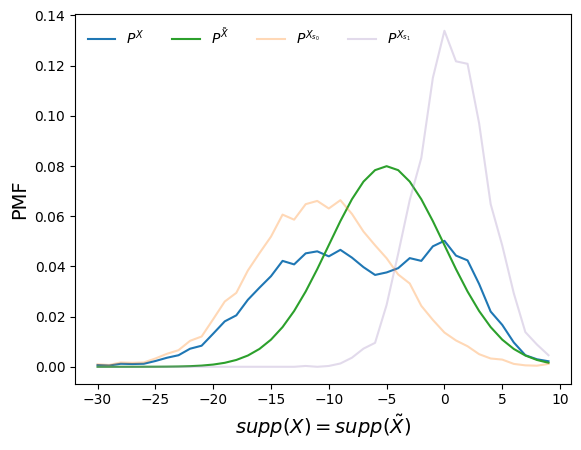

In [7]:
# make the overview plot
plt.plot(x_range,dist['x'],label=r'$P^{X}$',color='tab:blue')
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist['x_0'],label=r'$P^{X_{s_0}}$',alpha=0.3,color='tab:orange')
plt.plot(x_range,dist['x_1'],label=r'$P^{X_{s_1}}$',alpha=0.3,color='#9f86c0')
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'$supp(X)=supp(\tilde{X})$',fontsize=14)
plt.legend(ncol=4,frameon=False)
plt.savefig('../plots/SourceTarget_example.pdf',bbox_inches = 'tight')

## Compute & project repair outputs

In [8]:
# computation of couplings and projection
rdata_base=projection(data,run_repair(method="baseline", C=C, eps=e, px=px, ptx=ptx, V=V, K=K),x_range)
rdata_part2=projection(data,run_repair(method="partial_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K, theta=1.0e-2),x_range)
rdata_part3=projection(data,run_repair(method="partial_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K, theta=1.0e-3),x_range)
rdata_total=projection(data,run_repair(method="total_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K),x_range)

sum of violation of f: 0.002399003796690435
sum of violation of g: 1.5334409191383996e-16
total cost: 2.8619881967440284
entropy: 4.205242907904428
tr violation: [[1.23232043]]
sum of violation of f: 0.0005036680957375518
sum of violation of g: 0.00020329051145803105
total cost: 5.242386546925261
entropy: 4.831696488475644
tr violation: [[0.26125915]]
sum of violation of f: 0.002939042327637048
sum of violation of g: 4.514471310881792e-05
total cost: 5.996040352038294
entropy: 4.953266982560322
tr violation: [[0.03136845]]
sum of violation of f: 0.0012277865808776969
sum of violation of g: 1.4809849278890273e-06
total cost: 6.117612225758367
entropy: 4.971074273926628
tr violation: [[5.18055784e-09]]


In [9]:
# computation of empirical distributions
dist_origin=rdata_analysis(data,x_range)

rdist_base=rdata_analysis(rdata_base,x_range)
rdist_part2=rdata_analysis(rdata_part2,x_range)
rdist_part3=rdata_analysis(rdata_part3,x_range)
rdist_total=rdata_analysis(rdata_total,x_range)

## Compare projected PMFs

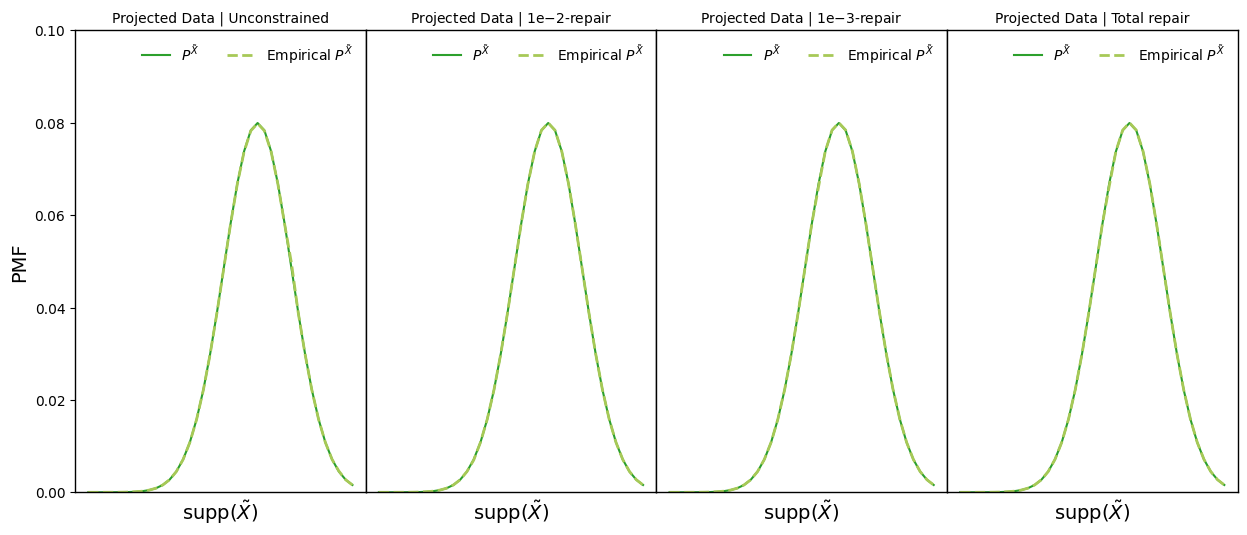

In [10]:
ymax=0.1
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,4),(0,0), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.xticks([])
plt.ylabel('PMF',fontsize=14)
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Unconstrained',fontsize=10)
ax=plt.subplot2grid((1,4),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
ax=plt.subplot2grid((1,4),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist['t_x'],label=r'$P^{\tilde{X}}$',color='tab:green')
plt.plot(x_range,dist_tmp['x'],label=r'Empirical $P^{\tilde{X}}$',color='#A7C957',linestyle='--',linewidth=2)
plt.ylim([0,ymax])
plt.legend(ncol=2,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('../plots/groupblind.pdf',bbox_inches = 'tight')

## Group-wise comparison

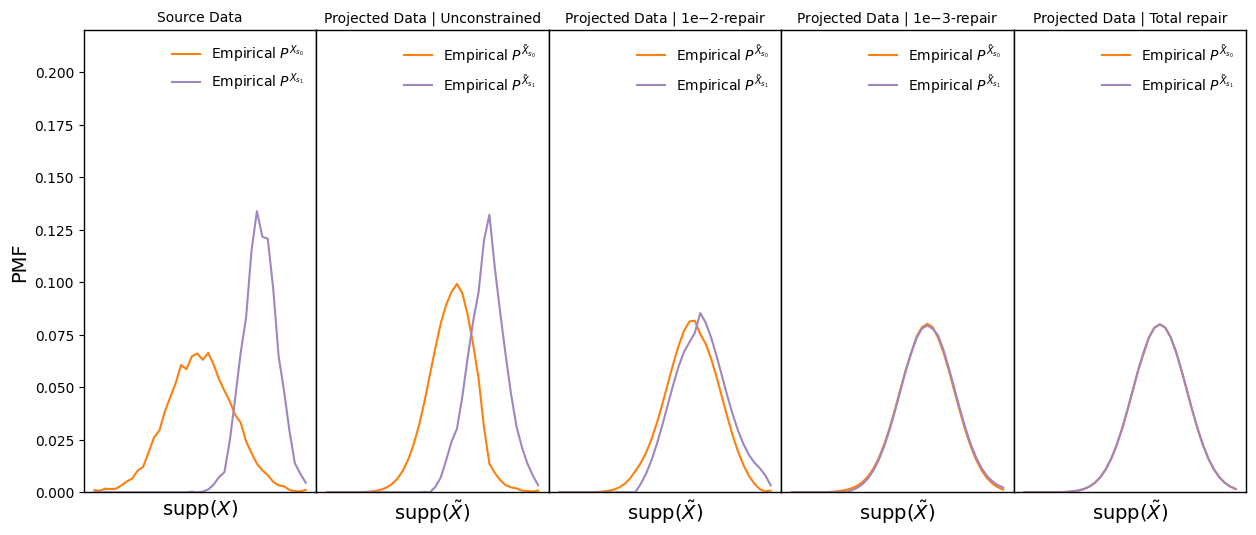

In [11]:
ymax=0.22
fig = plt.figure(figsize=(15,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,5),(0,0), rowspan=1, colspan=1)
dist_tmp=dist_origin
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{X_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{X_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.xticks([])
plt.xlabel(r'supp($X$)',fontsize=14)
plt.ylabel('PMF',fontsize=14)
plt.title('Source Data',fontsize=10)
ax=plt.subplot2grid((1,5),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_base
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Unconstrained',fontsize=10)
ax=plt.subplot2grid((1,5),(0,2), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-2}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,3), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title(r'Projected Data | $1\mathrm{e}{-3}$-repair',fontsize=10)
ax=plt.subplot2grid((1,5),(0,4), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.legend(ncol=1,frameon=False)
plt.yticks([])
plt.xticks([])
plt.xlabel(r'supp($\tilde{X}$)',fontsize=14)
plt.title('Projected Data | Total repair',fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
plt.savefig('../plots/groupwise.pdf',bbox_inches = 'tight')

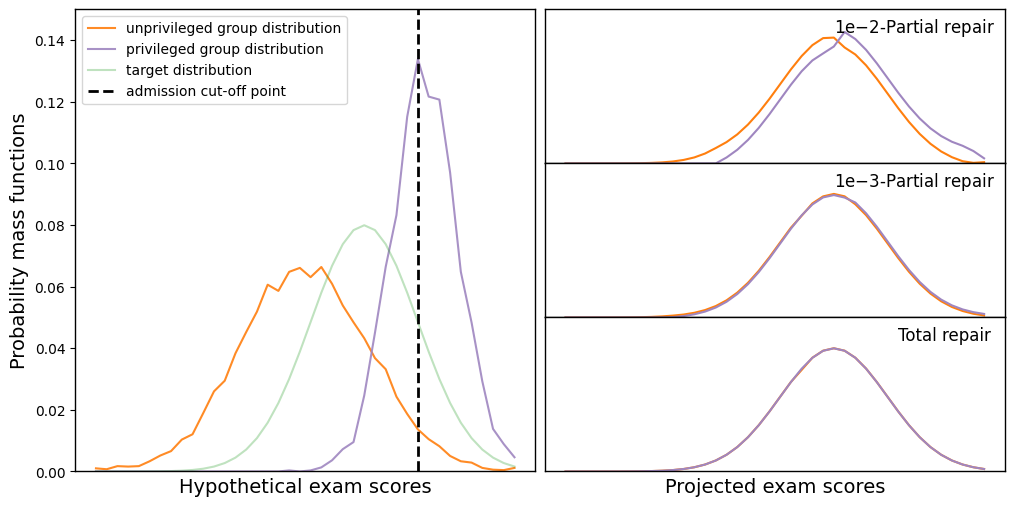

In [12]:
ymax=0.1
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((3,2),(0,0), rowspan=3, colspan=1)
plt.plot(x_range,dist['x_0'],label='unprivileged group distribution',alpha=0.9,color='tab:orange')
plt.plot(x_range,dist['x_1'],label='privileged group distribution',alpha=0.9,color='#9f86c0')
#plt.plot(x_range,dist['x'],label='group-blind distribution',color='tab:blue')
plt.plot(x_range,dist['t_x'],label='target distribution',alpha=0.3,color='tab:green')
plt.axvline(x=0, color='black', label='admission cut-off point',ls='--', lw=2)
plt.xticks([])
plt.ylim([0,0.15])
plt.ylabel('Probability mass functions',fontsize=14)
plt.xlabel('Hypothetical exam scores',fontsize=14)
plt.legend()
ax=plt.subplot2grid((3,2),(0,1), rowspan=1, colspan=1)
dist_tmp=rdist_part2
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-2}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(1,1), rowspan=1, colspan=1)
dist_tmp=rdist_part3
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.text(-5, 0.085, r'$1\mathrm{e}{-3}$-Partial repair', fontsize=12)
ax=plt.subplot2grid((3,2),(2,1), rowspan=1, colspan=1)
dist_tmp=rdist_total
plt.plot(x_range,dist_tmp['x_0'],label=r'Empirical $P^{\tilde{X}_{s_0}}$',color='tab:orange')
plt.plot(x_range,dist_tmp['x_1'],label=r'Empirical $P^{\tilde{X}_{s_1}}$',color='#9f86c0')
plt.ylim([0,ymax])
plt.yticks([])
plt.xticks([])
plt.xlabel('Projected exam scores',fontsize=14)
plt.text(1, 0.085, 'Total repair', fontsize=12)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02,hspace=0.)
# plt.savefig('C:/Users/zhouq/Downloads/motivation_example.pdf',bbox_inches = 'tight')

## Coupling heatmaps

sum of violation of f: 0.002399003796690435
sum of violation of g: 1.5334409191383996e-16
total cost: 2.8619881967440284
entropy: 4.205242907904428
tr violation: [[1.23232043]]


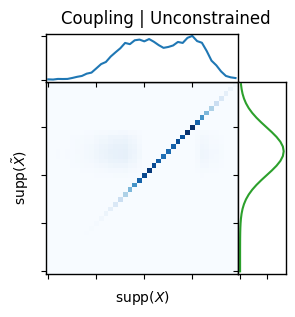

In [13]:
fig=plots(x_range,dist['x'],dist['t_x'],run_repair(method="baseline", C=C, eps=e, px=px, ptx=ptx, V=V, K=K).T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Unconstrained')
plt.savefig('../plots/coupling_base.pdf',bbox_inches = 'tight')

sum of violation of f: 0.0005036680957375518
sum of violation of g: 0.00020329051145803105
total cost: 5.242386546925261
entropy: 4.831696488475644
tr violation: [[0.26125915]]


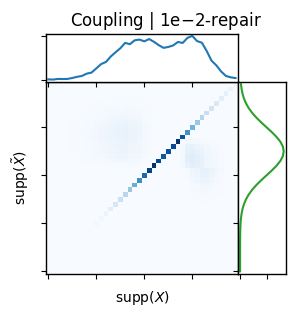

In [14]:
fig=plots(x_range,dist['x'],dist['t_x'],run_repair(method="partial_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K, theta=1.0e-2).T.A1.reshape((bin,bin)))
fig.suptitle(r'Coupling | $1\mathrm{e}{-2}$-repair')
plt.savefig('../plots/coupling_part2.pdf',bbox_inches = 'tight')

sum of violation of f: 0.002939042327637048
sum of violation of g: 4.514471310881792e-05
total cost: 5.996040352038294
entropy: 4.953266982560322
tr violation: [[0.03136845]]


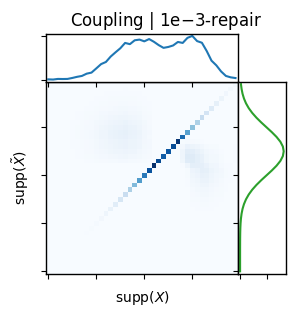

In [15]:
fig=plots(x_range,dist['x'],dist['t_x'],run_repair(method="partial_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K, theta=1.0e-3).T.A1.reshape((bin,bin)))
fig.suptitle(r'Coupling | $1\mathrm{e}{-3}$-repair')
plt.savefig('../plots/coupling_part3.pdf',bbox_inches = 'tight')

sum of violation of f: 0.0012277865808776969
sum of violation of g: 1.4809849278890273e-06
total cost: 6.117612225758367
entropy: 4.971074273926628
tr violation: [[5.18055784e-09]]


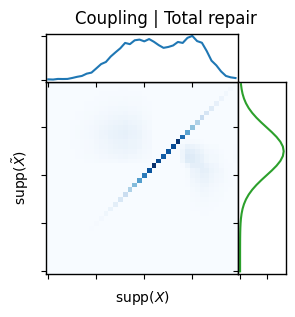

In [16]:
fig=plots(x_range,dist['x'],dist['t_x'],run_repair(method="total_repair", C=C, eps=e, px=px, ptx=ptx, V=V, K=K).T.A1.reshape((bin,bin)))
fig.suptitle('Coupling | Total repair')
plt.savefig('../plots/coupling_total.pdf',bbox_inches = 'tight')